In [1]:
from pandas_datareader import data as web
import numpy as np
import pandas as pd
from sklearn import mixture as mix
import seaborn as sns 
import matplotlib.pyplot as plt
import talib as ta
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import yfinance as yf
import datetime as dt

In [2]:
ticker = 'ETH-USD'
start = dt.datetime(2010,1,1).date()
end = dt.datetime.today().date()
df= pd.DataFrame(yf.download([ticker],start,end))
df=df[['Open','High','Low','Close']]

[*********************100%***********************]  1 of 1 completed


In [3]:
n = 10
# t = 0.1
# split =int(t*len(df))

df['high']=df['High'].shift(1)
df['low']=df['Low'].shift(1)
df['close']=df['Close'].shift(1)
df['RSI']=ta.RSI(np.array(df['close']), timeperiod=n)
df['SMA']= df['close'].rolling(window=n).mean()
df['Corr']= df['SMA'].rolling(window=n).corr(df['close'])
df['SAR']=ta.SAR(np.array(df['high']),np.array(df['low']),\
                  0.2,0.2)
df['ADX']=ta.ADX(np.array(df['high']),np.array(df['low']),\
                  np.array(df['close']), timeperiod =n)
df['Corr'][df.Corr>1]=1
df['Corr'][df.Corr<-1]=-1 
df['Return']= np.log(df['Open']/df['Open'].shift(1))

df=df.dropna()
df.head(5)

,Open,High,Low,Close,high,low,close,RSI,SMA,Corr,SAR,ADX,Return
Date,,,,,,,,,,,,,
2015-08-27,1.16981,1.18883,1.13729,1.14770,1.20248,1.06183,1.15998,32.497316,1.267299,0.875566,1.418842,22.631348,0.032158
2015-08-28,1.14766,1.20779,1.12050,1.19138,1.18883,1.13729,1.14770,32.276354,1.261708,0.911504,1.347440,23.205722,-0.019116
2015-08-29,1.19353,1.20721,1.14949,1.18255,1.20779,1.12050,1.19138,34.048635,1.272141,0.909849,1.290318,23.562195,0.039190
2015-08-30,1.18299,1.36799,1.17061,1.31927,1.20721,1.14949,1.18255,33.849666,1.264510,0.910740,1.244620,23.883021,-0.008870
2015-08-31,1.32138,1.39615,1.20101,1.35824,1.36799,1.17061,1.31927,39.892486,1.249945,0.789370,1.061830,22.704819,0.110632


In [4]:
unsup = mix.GaussianMixture(n_components=4, 
                            covariance_type="spherical", 
                            n_init=100, 
                            random_state=42)
unsup.fit(np.reshape(df,(-1,df.shape[1])))
regime = unsup.predict(np.reshape(df,(-1,df.shape[1])))
df['Return']= np.log(df['close']/df['close'].shift(1))
Regimes=pd.DataFrame(regime,columns=['Regime'],index=df.index)\
                     .join(df, how='inner')\
                          .assign(market_cu_return=df.Return.cumsum())\
                                 .reset_index(drop=False)\
                                             .rename(columns={'index':'Date'})

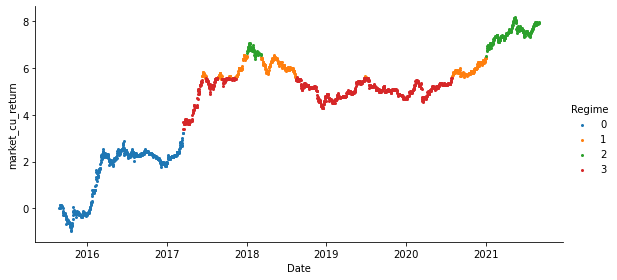

In [5]:
order=[0,1,2,3]
fig = sns.FacetGrid(data=Regimes,hue='Regime',hue_order=order,aspect=2,height=4)
fig.map(plt.scatter,'Date','market_cu_return', s=4).add_legend()
plt.show()

In [6]:
for i in order:
    print('Mean for regime %i: '%i,unsup.means_[i][0])
    print('Co-Variance for regime %i: '%i,(unsup.covariances_[i]))

Mean for regime 0:  8.191499647642235
Co-Variance for regime 0:  59.63354184346296
Mean for regime 1:  481.4929608512777
Co-Variance for regime 1:  12259.033232188534
Mean for regime 2:  1956.1463784044884
Co-Variance for regime 2:  441176.10068982164
Mean for regime 3:  189.73245284327788
Co-Variance for regime 3:  3021.2303204572663


In [7]:
Regimes.head(5)

,Date,Regime,Open,High,Low,Close,high,low,close,RSI,SMA,Corr,SAR,ADX,Return,market_cu_return
0,2015-08-27,0,1.16981,1.18883,1.13729,1.14770,1.20248,1.06183,1.15998,32.497316,1.267299,0.875566,1.418842,22.631348,NaN,NaN
1,2015-08-28,0,1.14766,1.20779,1.12050,1.19138,1.18883,1.13729,1.14770,32.276354,1.261708,0.911504,1.347440,23.205722,-0.010643,-0.010643
2,2015-08-29,0,1.19353,1.20721,1.14949,1.18255,1.20779,1.12050,1.19138,34.048635,1.272141,0.909849,1.290318,23.562195,0.037352,0.026710
3,2015-08-30,0,1.18299,1.36799,1.17061,1.31927,1.20721,1.14949,1.18255,33.849666,1.264510,0.910740,1.244620,23.883021,-0.007439,0.019270
4,2015-08-31,0,1.32138,1.39615,1.20101,1.35824,1.36799,1.17061,1.31927,39.892486,1.249945,0.789370,1.061830,22.704819,0.109405,0.128676


In [8]:
ss1 = StandardScaler()
columns =Regimes.columns.drop(['Regime','Date'])    
Regimes[columns]= ss1.fit_transform(Regimes[columns])
Regimes['Signal']=0
Regimes.loc[Regimes['Return']>0,'Signal']=1
Regimes.loc[Regimes['Return']<0,'Signal']=0
Regimes['return'] = Regimes['Return'].shift(1)
Regimes=Regimes.dropna()

In [45]:
cls= SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)

In [46]:
split2= int(.7*len(Regimes))

X = Regimes.drop(['Signal','Return','market_cu_return','Date'], axis=1)
y= Regimes['Signal']
from sklearn.model_selection import cross_val_score
scores = cross_val_score(cls, X, y, cv=8)



In [47]:
scores.mean()

0.7048357664233577

<AxesSubplot:>

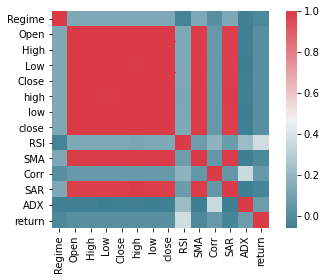

In [67]:
import seaborn as sns
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

In [65]:
parameters = corr.mean(axis=1)
parameters.sort_values(ascending = False)

High      0.660699
close     0.660319
Open      0.660316
high      0.660071
Close     0.659809
Low       0.659346
low       0.659328
SMA       0.651308
SAR       0.646634
RSI       0.196439
Corr      0.152436
Regime    0.148195
return    0.109583
ADX       0.076427
dtype: float64

In [53]:
cls.fit(X[:split2],y[:split2])

p_data=len(X)-split2

df['Pred_Signal']=0
df.iloc[-p_data:,df.columns.get_loc('Pred_Signal')]=cls.predict(X[split2:])

#print(df['Pred_Signal'][-p_data:])

In [75]:
df['str_ret'] = df['Pred_Signal']*df['Return'].shift(-1)
df['strategy_cu_return']=0.
df['market_cu_return']=0.

df.iloc[-p_data:,df.columns.get_loc('strategy_cu_return')] = np.nancumsum(df['str_ret'][-p_data:])
df.iloc[-p_data:,df.columns.get_loc('market_cu_return')] = np.nancumsum(df['Return'][-p_data:])
Sharpe = (df['strategy_cu_return'][-1]-df['market_cu_return'][-1])/np.nanstd(df['strategy_cu_return'][-p_data:])

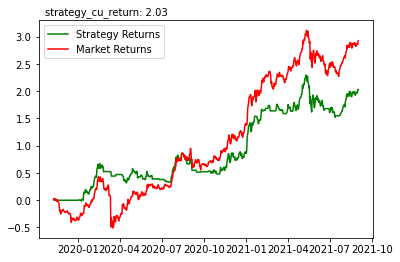

In [76]:
plt.plot(df['strategy_cu_return'][-p_data:],color='g',label='Strategy Returns')
plt.plot(df['market_cu_return'][-p_data:],color='r',label='Market Returns')
plt.figtext(0.14,0.9,s='strategy_cu_return: %.2f'% (df['strategy_cu_return'][-1]))
#plt.figtext(0.14,0.9,s='strategy_cu_return'%(df['strategy_cu_return'][-1]-1)
plt.legend(loc='best')
plt.show()

In [77]:
X


,Regime,Open,High,Low,Close,high,low,close,RSI,SMA,Corr,SAR,ADX,return
2,0,-0.634438,-0.631707,-0.637278,-0.633583,-0.632337,-0.637821,-0.634393,-1.160021,-0.637871,1.043338,-0.633174,-0.889176,-0.237992
3,0,-0.634453,-0.631487,-0.637247,-0.633389,-0.632338,-0.637778,-0.634405,-1.171992,-0.637882,1.045043,-0.633241,-0.866622,0.561473
4,0,-0.634255,-0.631448,-0.637201,-0.633334,-0.632117,-0.637746,-0.634210,-0.808431,-0.637903,0.812686,-0.633507,-0.949450,-0.184628
5,0,-0.634210,-0.631453,-0.636998,-0.633343,-0.632078,-0.637700,-0.634154,-0.706750,-0.637909,0.271806,-0.633418,-1.041351,1.761672
6,0,-0.634212,-0.631505,-0.637106,-0.633424,-0.632083,-0.637496,-0.634164,-0.719977,-0.637913,-0.473504,-0.633348,-1.124062,0.424198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,2,4.043401,3.861831,4.184672,3.976629,3.878658,3.975261,4.037390,0.304948,4.035789,0.570597,4.167082,-1.048571,-0.716997
2190,2,4.002917,3.859627,4.096871,3.951894,3.882790,4.205539,3.999955,0.208480,4.068517,0.093549,3.819524,-1.189487,0.829890
2191,2,3.974943,3.946313,4.085783,3.948157,3.880576,4.117349,3.975091,0.140616,4.074981,-0.206459,3.825719,-1.262489,-0.194673
2192,2,3.975751,4.111091,4.151408,4.245759,3.967678,4.106212,3.971335,0.129489,4.065853,0.075542,3.889872,-1.371043,-0.150289


In [78]:
df['Pred_Signal']

Date
2015-08-27    0
2015-08-28    0
2015-08-29    0
2015-08-30    0
2015-08-31    0
             ..
2021-08-28    1
2021-08-29    1
2021-08-30    1
2021-08-31    1
2021-09-01    1
Name: Pred_Signal, Length: 2194, dtype: int64